#0- Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ProjetML/data/scitweets_export.tsv', sep='\t')

display(data.head())

,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,Knees are a bit sore. i guess that's a sign th...,0,0.0,0.0,0.0
1,1,319090866545385472,McDonald's breakfast stop then the gym 🏀💪,0,0.0,0.0,0.0
2,2,322030931022065664,Can any Gynecologist with Cancer Experience ex...,1,1.0,0.0,0.0
3,3,322694830620807168,Couch-lock highs lead to sleeping in the couch...,1,1.0,0.0,0.0
4,4,328524426658328576,Does daily routine help prevent problems with ...,1,1.0,0.0,0.0


# Classifiers

# Fonction générale pour traiter tous les cas

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
def split_data(X,y,test_len=0.2):
  # Split train/test
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=test_len, random_state=42,stratify=y
      )
  return X_train, X_test, y_train, y_test

In [12]:
def run_classification(X,y,X_train, X_test, y_train, y_test, model_type="random_forest", n_classes=2, show_confusion=True):
    """
    Lance une classification avec TF-IDF + modèle (RandomForest ou LogisticRegression).

    :param X: Series ou liste de textes
    :param y: Series ou liste de labels (binaire ou multiclasses)
    :param model_type: "random_forest" ou "logistic_regression"
    :param n_classes: 2 (binaire) ou 3 (multiclasses)
    :param show_confusion: bool, afficher ou non la matrice de confusion
    :return: None
    """



    # Choix du modèle
    if model_type == "random_forest":
        model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    elif model_type == "logistic_regression":
        model = LogisticRegression(class_weight='balanced', max_iter=1000, solver='lbfgs')
    else:
        raise ValueError("model_type doit être 'random_forest' ou 'logistic_regression'.")

    # Pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2))),  # Unigrammes + bigrammes
        ('classifier', model)
    ])

    # Train
    pipeline.fit(X_train, y_train)

    # Prédictions
    y_pred = pipeline.predict(X_test)

    # Évaluation
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # Matrice de confusion
    if show_confusion:
        labels = sorted(list(set(y)))  # Récupérer les classes dans l'ordre
        cm = confusion_matrix(y_test, y_pred, labels=labels)
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    return pipeline


Accuracy: 0.7763157894736842
              precision    recall  f1-score   support

           0       0.76      0.99      0.86       153
           1       0.93      0.35      0.50        75

    accuracy                           0.78       228
   macro avg       0.84      0.67      0.68       228
weighted avg       0.81      0.78      0.74       228



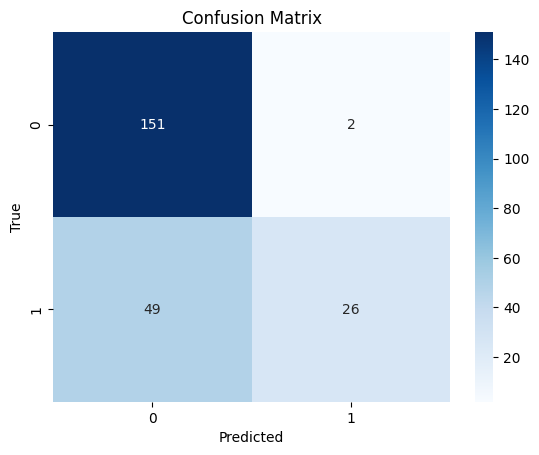

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [13]:
X_train, X_test, y_train, y_test = split_data(X=data["text"].astype(str), y=data["science_related"])
run_classification(data["text"].astype(str), data["science_related"],X_train, X_test, y_train, y_test, model_type="random_forest", n_classes=2)  #SCI vs NON SCI

Accuracy: 0.9066666666666666
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.91      1.00      0.95        68

    accuracy                           0.91        75
   macro avg       0.45      0.50      0.48        75
weighted avg       0.82      0.91      0.86        75



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


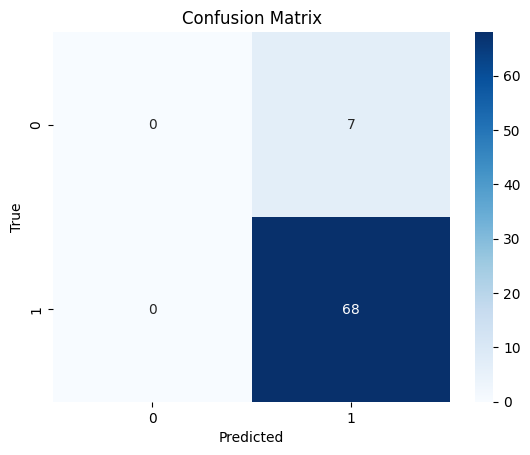

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [14]:
sci_tweets = data[data['science_related'] == 1].copy() # CLAIM,REF VS CONTEXT
sci_tweets['claim_or_ref'] = ((sci_tweets['scientific_claim'] == 1) |
                             (sci_tweets['scientific_reference'] == 1)).astype(int)

X_train, X_test, y_train, y_test = split_data(X=sci_tweets["text"], y=sci_tweets["claim_or_ref"])

run_classification(sci_tweets["text"], sci_tweets["claim_or_ref"],X_train, X_test, y_train, y_test, model_type="random_forest", n_classes=2)

Accuracy: 0.6266666666666667
              precision    recall  f1-score   support

       CLAIM       0.78      0.25      0.38        28
     CONTEXT       0.00      0.00      0.00         7
         REF       0.61      1.00      0.75        40

    accuracy                           0.63        75
   macro avg       0.46      0.42      0.38        75
weighted avg       0.61      0.63      0.54        75



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


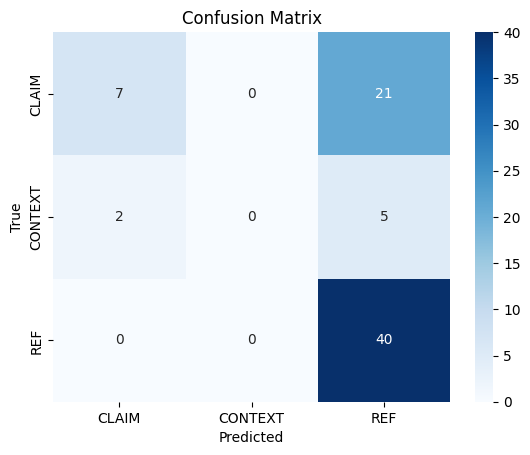

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [17]:
sci_tweets['category'] = 'CONTEXT'
sci_tweets.loc[sci_tweets['scientific_claim'] == 1, 'category'] = 'CLAIM'
sci_tweets.loc[sci_tweets['scientific_reference'] == 1, 'category'] = 'REF'
multi_label = ((sci_tweets['scientific_claim'] + sci_tweets['scientific_reference'] +
                sci_tweets['scientific_context']) > 1).sum()


X_train, X_test, y_train, y_test = split_data(X=sci_tweets["text"], y=sci_tweets["category"])


run_classification(sci_tweets["text"], sci_tweets["category"],X_train, X_test, y_train, y_test, model_type="random_forest", n_classes=3)

DATA CLEAN ET RE TEST DE SCI VS NON SCI

In [18]:
import pandas as pd
import re
import random
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.utils import resample

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

# Stopwords français ou anglais selon ton dataset
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Mise en minuscule
    text = text.lower()

    # Tokenisation
    tokens = word_tokenize(text)

    return " ".join(tokens)

def preprocess_and_balance(data):


    # Séparation des classes
    df_majority = df[df["science_related"] == 0]
    df_minority = df[df["science_related"] == 1]

    # Suréchantillonnage de la classe minoritaire
    df_minority_upsampled = resample(df_minority,
                                     replace=True,
                                     n_samples=len(df_majority),
                                     random_state=42)

    # Assemblage et mélange
    df_balanced = pd.concat([df_majority, df_minority_upsampled])
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

    return df_balanced[["text", "science_related"]]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Accuracy: 0.9868421052631579
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       153
           1       1.00      0.96      0.98        75

    accuracy                           0.99       228
   macro avg       0.99      0.98      0.98       228
weighted avg       0.99      0.99      0.99       228



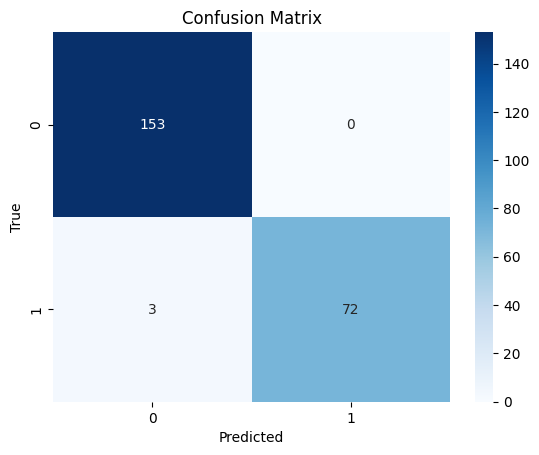

In [20]:

df = data.copy()


# 2. Split des données AVANT équilibrage
X_train, X_test, y_train, y_test = split_data(X=data["text"].astype(str), y=data["science_related"])

# 3. Crée un DataFrame d'entraînement pour rééquilibrage
train_df = pd.DataFrame({'text': X_train, 'science_related': y_train})

# 4. Rééquilibrage SEULEMENT sur l'entraînement
df_balanced = preprocess_and_balance(train_df)



# 5. Ré-entraînement avec le train équilibré et test non touché
pipeline = run_classification(
    data["text"].astype(str), data["science_related"],
    X_train=df_balanced["text"],
    X_test=X_test,
    y_train=df_balanced["science_related"],
    y_test=y_test,
    model_type="random_forest",
    n_classes=2
)

In [21]:
# Fonction de prédiction
def predict_tweet(tweet,pipeline):
    prediction = pipeline.predict([tweet])
    return "Scientifique" if prediction[0] == 1 else "Non scientifique"


In [22]:
def test_model(predict_tweet,pipeline):
    # Exemples de tweets scientifiques
    scientific_tweets = [
        "The discovery of gravitational waves opens up new possibilities for understanding the universe.",
        "Researchers have developed a new method for diagnosing Alzheimer's disease earlier than ever before.",
        "A study shows that exercise improves cognitive function in older adults.",
        "New research suggests a link between climate change and the increased frequency of natural disasters.",
        "Scientists have found evidence that black holes can merge to form a more massive object."
    ]

    scientific_tweets += [
    "A recent publication in Nature describes a breakthrough in quantum computing.",
    "NASA has confirmed the presence of water molecules on the sunlit surface of the Moon.",
    "A new vaccine shows 95% efficacy in clinical trials against the virus.",
    "The James Webb Space Telescope has captured the most detailed images of a distant galaxy.",
    "CRISPR gene editing has been successfully used to treat a rare genetic disorder.",
    "A new mathematical model predicts the spread of infectious diseases with high accuracy.",
    "Scientists detected neutrinos from a supernova explosion 170,000 light-years away.",
    "Research on dark matter could explain anomalies in galaxy rotation curves.",
    "The Large Hadron Collider begins a new round of experiments searching for supersymmetric particles.",
    "Biologists have discovered a new species of deep-sea jellyfish with bioluminescent properties."
]


    # Exemples de tweets non scientifiques
    non_scientific_tweets = [
        "Just had the best coffee at my favorite cafe this morning!",
        "Can't wait to hit the gym and work on those gains 💪.",
        "I love watching Netflix shows all day when I have free time.",
        "Had a great time at the beach today! The sun was perfect.",
        "Going to my friend's birthday party tonight, it's going to be a blast!"
    ]

    non_scientific_tweets += [
    "Just booked my summer vacation to Bali! Can't wait! 🏝️",
    "Listening to my favorite playlist while cooking dinner.",
    "Bought a new pair of sneakers today, they're so comfy!",
    "The traffic today was absolutely insane, took me 2 hours to get home.",
    "Had a great brunch with my family this Sunday.",
    "I can't believe my team lost the game last night!",
    "Trying out a new recipe tonight, hope it turns out well.",
    "Spending the weekend catching up on sleep and movies.",
    "My dog just did the cutest thing ever 🐶❤️",
    "Celebrating my promotion at work with a fancy dinner!"
]


    # Tester les tweets scientifiques
    for tweet in scientific_tweets:
        result = predict_tweet(tweet,pipeline)
        if result == "Scientifique":
            print(f"Test réussi pour le tweet scientifique : {tweet}")
        else:
            print(f"Test échoué pour le tweet scientifique : {tweet}")

    # Tester les tweets non scientifiques
    for tweet in non_scientific_tweets:
        result = predict_tweet(tweet,pipeline)
        if result == "Non scientifique":
            print(f"Test réussi pour le tweet non scientifique : {tweet}")
        else:
            print(f"Test échoué pour le tweet non scientifique : {tweet}")

# Appeler la fonction de test
test_model(predict_tweet,pipeline)

Test échoué pour le tweet scientifique : The discovery of gravitational waves opens up new possibilities for understanding the universe.
Test échoué pour le tweet scientifique : Researchers have developed a new method for diagnosing Alzheimer's disease earlier than ever before.
Test échoué pour le tweet scientifique : A study shows that exercise improves cognitive function in older adults.
Test réussi pour le tweet scientifique : New research suggests a link between climate change and the increased frequency of natural disasters.
Test échoué pour le tweet scientifique : Scientists have found evidence that black holes can merge to form a more massive object.
Test échoué pour le tweet scientifique : A recent publication in Nature describes a breakthrough in quantum computing.
Test échoué pour le tweet scientifique : NASA has confirmed the presence of water molecules on the sunlit surface of the Moon.
Test échoué pour le tweet scientifique : A new vaccine shows 95% efficacy in clinical tr

DATACLEAN ET RE TEST DE CLAIM ET REF VS CONTEXT

In [23]:
sci_tweets = data[data['science_related'] == 1].copy()

sci_tweets['claim_or_ref'] = (
    (sci_tweets['scientific_claim'] == 1) |
    (sci_tweets['scientific_reference'] == 1)
).astype(int)

In [24]:
from sklearn.utils import resample

def balance_binary_classes(df, text_col, label_col):
    df_majority = df[df[label_col] == 1]
    df_minority = df[df[label_col] == 0]


    df_minority_upsampled = resample(df_minority,
                                     replace=True,
                                     n_samples=len(df_majority),
                                     random_state=42)

    df_balanced = pd.concat([df_majority, df_minority_upsampled])

    return df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


Accuracy: 0.9066666666666666
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.91      1.00      0.95        68

    accuracy                           0.91        75
   macro avg       0.45      0.50      0.48        75
weighted avg       0.82      0.91      0.86        75



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


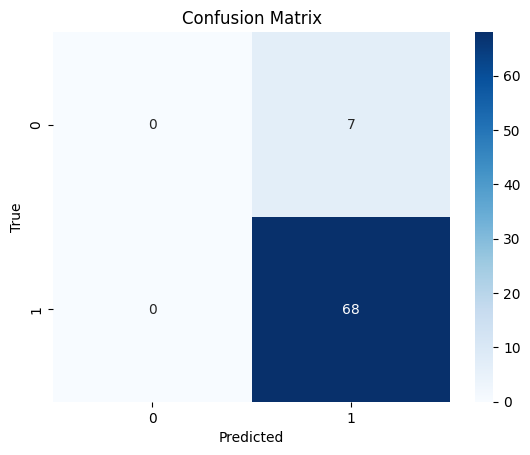

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [26]:

# 2. Split des données AVANT équilibrage
X_train, X_test, y_train, y_test = split_data(sci_tweets["text"], sci_tweets["claim_or_ref"],test_len=0.2)

# 3. Crée un DataFrame d'entraînement pour rééquilibrage
train_df = pd.DataFrame({'text': X_train, 'claim_or_ref': y_train})

# 4. Rééquilibrage SEULEMENT sur l'entraînement
train_df_balanced = balance_binary_classes(train_df, text_col='text', label_col='claim_or_ref')

# 5. Ré-entraînement avec le train équilibré et test non touché
run_classification(
    sci_tweets["text"], sci_tweets["claim_or_ref"],
    X_train=train_df_balanced["text"],
    X_test=X_test,
    y_train=train_df_balanced["claim_or_ref"],
    y_test=y_test,
    model_type="random_forest",
    n_classes=2
)


CLAIM VS REF VS CONTEXT CLEAN DATA

In [27]:
from sklearn.utils import resample

def balance_multiclass(df, text_col, label_col):
    classes = df[label_col].unique()
    max_size = df[label_col].value_counts().max()
    balanced_frames = []

    for cls in classes:
        cls_df = df[df[label_col] == cls]
        upsampled = resample(cls_df, replace=True, n_samples=max_size, random_state=42)
        balanced_frames.append(upsampled)

    df_balanced = pd.concat(balanced_frames)
    return df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


In [28]:
sci_tweets = data[data['science_related'] == 1].copy()

# Création de la colonne 'category' avec priorité CLAIM > REF > CONTEXT
sci_tweets['category'] = 'CONTEXT'
sci_tweets.loc[sci_tweets['scientific_reference'] == 1, 'category'] = 'REF'
sci_tweets.loc[sci_tweets['scientific_claim'] == 1, 'category'] = 'CLAIM'

In [29]:
X_train, X_test, y_train, y_test = split_data(
    X=sci_tweets["text"],
    y=sci_tweets["category"],
    test_len=0.2
)

# Création d’un DataFrame d'entraînement
train_df = pd.DataFrame({'text': X_train, 'category': y_train})


In [31]:
# Équilibrage sur le train uniquement
train_df_balanced = balance_multiclass(train_df, text_col='text', label_col='category')

print(train_df_balanced['category'].value_counts())


# Entraînement du modèle
run_classification(
    X=sci_tweets["text"],
    y=sci_tweets["category"],
    X_train=train_df_balanced["text"],
    X_test=X_test,
    y_train=train_df_balanced["category"],
    y_test=y_test,
    model_type="random_forest",
    n_classes=3,
    show_confusion=False

)


category
CONTEXT    211
CLAIM      211
REF        211
Name: count, dtype: int64
Accuracy: 0.4533333333333333
              precision    recall  f1-score   support

       CLAIM       0.82      0.44      0.57        52
     CONTEXT       0.00      0.00      0.00         7
         REF       0.23      0.69      0.35        16

    accuracy                           0.45        75
   macro avg       0.35      0.38      0.31        75
weighted avg       0.62      0.45      0.47        75



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])